In [18]:
import pandas as pd
import numpy as np
df = pd.read_csv("amazon_reviews.csv")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
df = df.dropna(subset=['reviewText'])

In [4]:
def assign_sentiment(rating):
    if rating >= 4:
        return 1  # Positive
    elif rating <= 2:
        return 0  # Negative
    else:
        return None  # Neutral (optional to exclude)

df['Sentiment'] = df['overall'].apply(assign_sentiment)
df = df.dropna(subset=['Sentiment'])

In [5]:
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text
df['cleaned_review'] = df['reviewText'].apply(clean_text)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95)
X = vectorizer.fit_transform(df['cleaned_review'])
y = df['Sentiment']

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
def clean_text_advanced(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_review'] = df['reviewText'].apply(clean_text_advanced)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\subra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9434554973821989
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.20      0.33        66
         1.0       0.94      1.00      0.97       889

    accuracy                           0.94       955
   macro avg       0.94      0.60      0.65       955
weighted avg       0.94      0.94      0.93       955



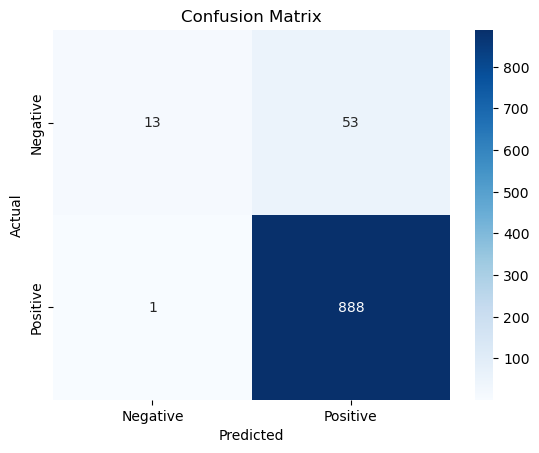

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Save the model for future use
import joblib
joblib.dump(model, 'sentiment.pkl')
model_loaded = joblib.load('sentiment.pkl')
y_pred_loaded = model_loaded.predict(X_test)
print("Model loaded successfully. Predicting on test data...")
print("Accuracy of loaded model:", accuracy_score(y_test, y_pred_loaded))
print("Classification Report of loaded model:\n", classification_report(y_test, y_pred_loaded))


Model loaded successfully. Predicting on test data...
Accuracy of loaded model: 0.9434554973821989
Classification Report of loaded model:
               precision    recall  f1-score   support

         0.0       0.93      0.20      0.33        66
         1.0       0.94      1.00      0.97       889

    accuracy                           0.94       955
   macro avg       0.94      0.60      0.65       955
weighted avg       0.94      0.94      0.93       955



C:\Users\subra\AppData\Local\Temp\ipykernel_2096\1871329249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


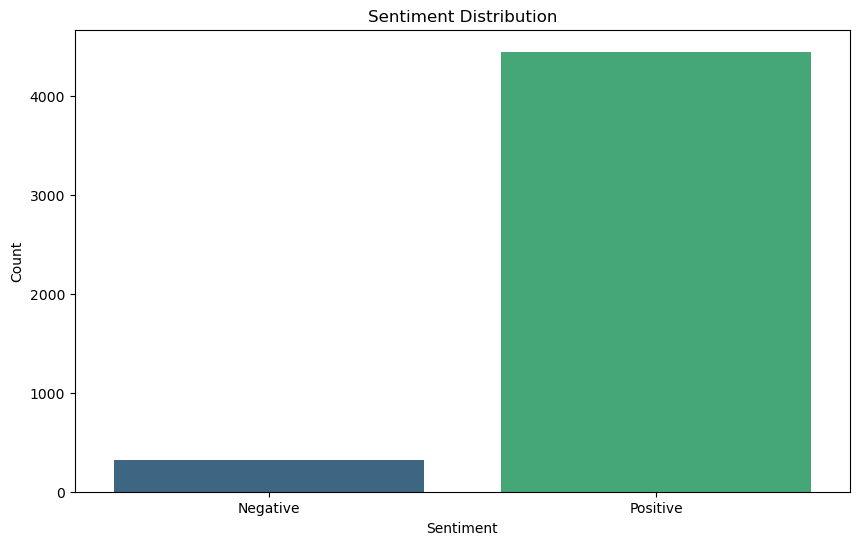

In [10]:
#sentiment evaluation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df, palette='viridis')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

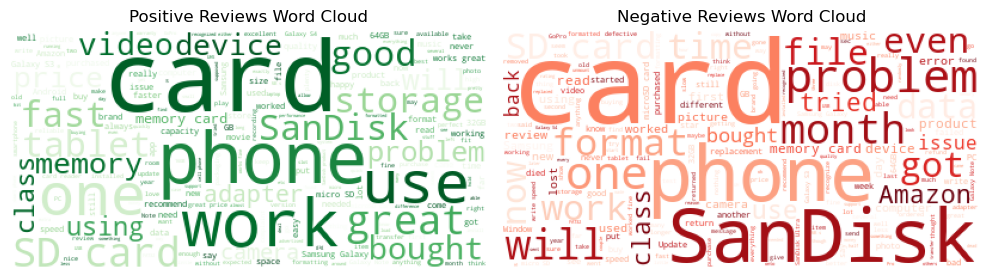

In [14]:
from wordcloud import WordCloud

# positive and negative word cloud
positive_text = ' '.join(df[df['Sentiment'] == 1.0]['reviewText'][:500])
negative_text = ' '.join(df[df['Sentiment'] == 0.0]['reviewText'][:500])

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white', colormap='Greens').generate(positive_text))
plt.axis('off')
plt.title('Positive Reviews Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='white', colormap='Reds').generate(negative_text))
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.tight_layout()
plt.show()

In [16]:
from collections import Counter
import re

def get_top_words(texts,n=10):
    words=" ".join(texts).lower()
    words = re.findall(r'\b\w+\b', words)
    return Counter(words).most_common(n)

print("Top 10 words in positive reviews:")
top_words = get_top_words(df[df['Sentiment'] == 1.0]['reviewText'], 10)
for word, count in top_words:
    print(f"{word}: {count}")
print("Top 10 words in negative reviews:")
top_words_negative = get_top_words(df[df['Sentiment'] == 0.0]['reviewText'], 10)
for word, count in top_words_negative:
    print(f"{word}: {count}")

Top 10 words in positive reviews:
i: 7469
the: 7255
and: 6447
it: 6241
to: 5044
a: 4530
my: 4371
this: 3888
card: 3632
for: 3578
Top 10 words in negative reviews:
the: 1489
i: 1483
it: 1059
and: 904
to: 854
card: 849
a: 821
my: 540
this: 531
of: 475
